In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pyspectrum import Spectrum, Peak, FindPeaksDomain, germanium_fwhm, TimeChannelParser
from pyPAS import PASdb, PAScdb, PasCoincidenceFilter
from uncertainties import ufloat, nominal_value, std_dev

In [2]:
# This turtorial presents how to use PAS objects for defect parameter calculations
# the pas objects defined are PASdb and PAScdb

# PASdb example

In [8]:
# the data files from the detector (time stamps and channel)
file = './libs/PASdb/db_spectrum'

energy_calib_poly = np.poly1d([0.0408976444, 0.0822321508])
energy_resolution_det = 1.05 
estimated_FWHM_det = lambda energy: germanium_fwhm(energy, 0, energy_resolution_det/511**0.5, 0)

In [9]:
# defined db
db = PASdb.from_file(file, energy_calib_poly, estimated_FWHM_det, skiprows=1)

In [10]:
# PASdb is derived from Peak class, and thus holds all spectrum properties
# for more information on spectrum properties spectrum and peak turtorial is on the git 
# in PASdb it also possible to calculate the defect parameter easily
# uncertanties are calculated with uncertanties package
energy_domain_s = [510.1,511.9]
energy_domain_w_l = [506,509.3]
energy_domain_w_r = [512.7,516]
total_energy_domain = [506.8, 516]
db.s_parameter_calculation(total_energy_domain, energy_domain_s), db.w_parameter_calculation(total_energy_domain, energy_domain_w_l, energy_domain_w_r)

(<xarray.DataArray 'channel' ()>
 array(0.5404974751366595+/-0.0006878951251225896, dtype=object),
 <xarray.DataArray 'channel' ()>
 array(0.19930684414762884+/-0.0005587758616863623, dtype=object))

# PAScdb example

first we load the data with the right parameters

In [3]:
# the data files from the detector (time stamps and channel)
file_1 = './libs/PASdb/cdb_time_channel_detector_1.txt'
file_2 = './libs/PASdb/cdb_time_channel_detector_2.txt'
# defnitions from the calibration

energy_calib_poly_det_1 = np.poly1d([0.0408976444, 0.0822321508])
energy_calib_poly_det_2 = np.poly1d([0.0418921521, 0.0653720462])

energy_resolution_det_1 = 1.05 
energy_resolution_det_2 = 1.08 
estimated_FWHM_det_1 = lambda energy: germanium_fwhm(energy, 0, energy_resolution_det_1/511**0.5, 0)
estimated_FWHM_det_2 = lambda energy: germanium_fwhm(energy, 0, energy_resolution_det_2/511**0.5, 0)



we want to recalibratethe energy because the center should be at 511 keV

In [4]:
data_detector_1 = TimeChannelParser.to_dataframe(file_1)
spectrum_detector_1 = Spectrum.from_dataframe(TimeChannelParser.counts_in_time_into_spectrum(data_detector_1), energy_calib_poly_det_1, estimated_FWHM_det_1)
db_detector_1 = PASdb.from_spectrum(spectrum_detector_1)
spec_energy_measured = energy_calib_poly_det_1(data_detector_1.channel)

data_detector_2 = TimeChannelParser.to_dataframe(file_2)
spectrum_detector_2 = Spectrum.from_dataframe(TimeChannelParser.counts_in_time_into_spectrum(data_detector_2), energy_calib_poly_det_2, estimated_FWHM_det_2)
db_detector_2 = PASdb.from_spectrum(spectrum_detector_2)
spec_energy_measured = energy_calib_poly_det_1(data_detector_2.channel)

# recalibrate
calibration_correction_detector_1 = nominal_value(db_detector_1.first_moment_method_center())- 511
calibration_correction_detector_2 = nominal_value(db_detector_2.first_moment_method_center())- 511

energy_calib_poly_det_1 = np.poly1d([0.0408976444, 0.0822321508 - calibration_correction_detector_1])
energy_calib_poly_det_2 = np.poly1d([0.0418921521, 0.0653720462 - calibration_correction_detector_2])


with the new calibration,  filter the cdb

In [5]:
# get the dataframe of all the valid cdb instances
# Note tat 3 sigmas gives 99 % of the events, however,
# actually comparing data with 2 and 3 sigma shows that junk events start enters 
cdb_pairs = PasCoincidenceFilter.from_files(file_1, file_2,
                                            sep=' ', skiprows=5,
                                            det_1_energy_calibration_poly=energy_calib_poly_det_1, det_2_energy_calibration_poly=energy_calib_poly_det_2,
                                            det_1_energy_resolution=energy_resolution_det_1, det_2_energy_resolution=energy_resolution_det_2,
                                            max_time_interval=10, number_of_cdb_sigma=2)
# make cdb instance
cdb = PAScdb(cdb_pairs)

Text(0.5, 1.0, 'cdb of Cu (annealed to 250 degrees) measurement')

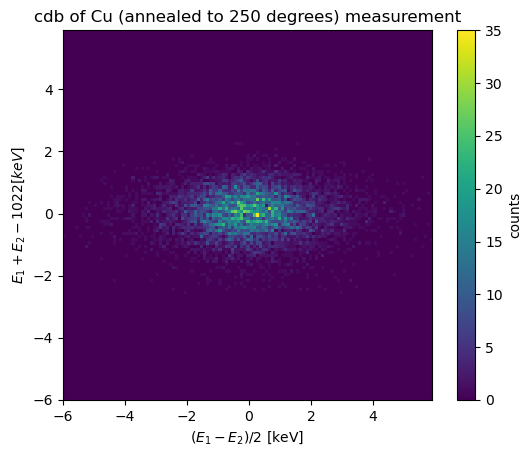

In [6]:
hist_2d, X_edges, Y_edges = cdb.histogram_2d([-6, 6], mesh_interval=0.1)

fig, ax = plt.subplots()
cax = plt.imshow(hist_2d, extent=[X_edges.min(),X_edges.max(),Y_edges.min(),Y_edges.max()], origin='lower')
fig.colorbar(cax, ax=ax, label='counts')
ax.set_xlabel('$(E_1 - E_2)/2$ [keV]')
ax.set_ylabel('$E_1 + E_2 - 1022 [keV]$')
plt.title('cdb of Cu (annealed to 250 degrees) measurement')


The db and resolution.
Notice the momentum distribution and how it opens in the high momenta, also note the resolution background (in some cases it's stronger)

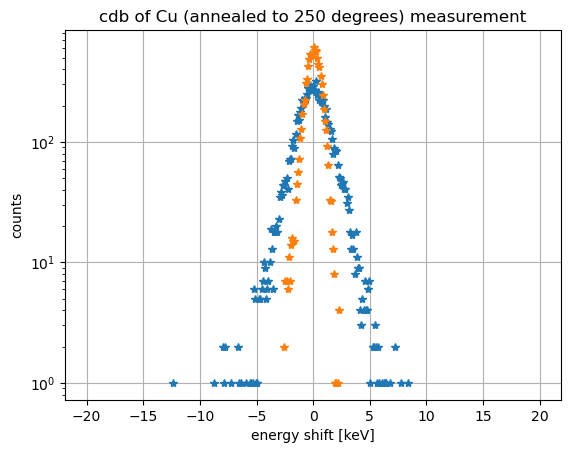

In [7]:

db_cdb = cdb.doppler_broadening_spectrum([-20,20], 0.1)
res_cdb = cdb.resolution_spectrum([-20,20], 0.1)
db_cdb.peak.plot(ls='',marker='*', yscale='log')
res_cdb.peak.plot(ls='',marker='*', yscale='log')
plt.ylabel('counts')
plt.xlabel('energy shift [keV]')
plt.title('cdb of Cu (annealed to 250 degrees) measurement')
plt.grid(True)